# Table of Contents
1. [Table of Contents](#Table-of-Contents)
2. [Brief Review of Statistics](#Brief-Review-of-Statistics)
3. [Simulation of Random Variables](#Simulation-of-Random-Variables)
    4. [[Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling)](#[Inverse-Transform-Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling))
    5. [[Rejection Sampling](https://en.wikipedia.org/wiki/Rejection_sampling)](#[Rejection-Sampling](https://en.wikipedia.org/wiki/Rejection_sampling))
6. [Introduction to Markov Chains](#Introduction-to-Markov-Chains)
    7. [Multistep Transition Probabilities](#Multistep-Transition-Probabilities)
    8. [Classification of States](#Classification-of-States)
    9. [Stationary Distributions](#Stationary-Distributions)
10. [Exam 1 Review Session](#Exam-1-Review-Session)
    11. [Question 1](#Question-1)
    12. [Question 2](#Question-2)
    13. [Question 3](#Question-3)
    14. [Question 4](#Question-4)

In [1]:
import numpy as np
import sympy as sp
from sympy import symbols
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import pydot

from IPython.display import display

sp.init_printing()

%matplotlib inline

# Brief Review of Statistics

See my other notes for a more complete intro, but the things that immediately matter are as follows.

* Conditional Probability
$$
P(B|A) = \frac{P(B \cup A)}{P(A)}
$$
* Independence
$$
P(A_0 \cap \ldots \cap A_n) = P(A_0) \cdots P(A_n)
$$

# Simulation of Random Variables

We can simulate any random variable with just a uniform distribution pretty easily and efficiently.

## [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling)

* Let $X$ be some rv with known cdf $F(x)$.
* We want values of $X$ according to this distribution
* Generate some $u\sim Uniform(0, 1)$.
* Compute the value $x$ such that $F(x) = u$.
* Take $x$ to be our number.


In [2]:
def get_empirical_cdf(data, k_vals):
    """
    Finds the empirical cdf from a dataset.

    :param data: np.ndarray => data for analysis
    :param k_vals: np.ndarray => values to use

    :return: np.ndarray for cdf
    """
    cdf = np.zeros(len(k_vals))
    n = len(data)
    for i in range(len(k_vals)):
        cdf[i] = len(data[data <= k_vals[i]])
    cdf *= (1 / n)
    return cdf

In [3]:
def simulate_rv_cdf(func):
    x = np.arange(-1, 3, 0.01)
    uniform_vars = np.random.random(size=1000)
    simulated_vars = np.zeros(len(uniform_vars))
    for i, val in enumerate(uniform_vars):
        simulated_vars[i] = ((2 * val + 1)**2 - 1) / 4
    empirical_cdf = get_empirical_cdf(simulated_vars, np.linspace(0, 2, 100))
    
    plt.figure()
    plt.plot(x, func(x), label='Known CDF')
    plt.plot(np.linspace(0, 2, 100), empirical_cdf, label='Empirical CDF (simulated)')
    plt.legend(loc=0)
    plt.show()

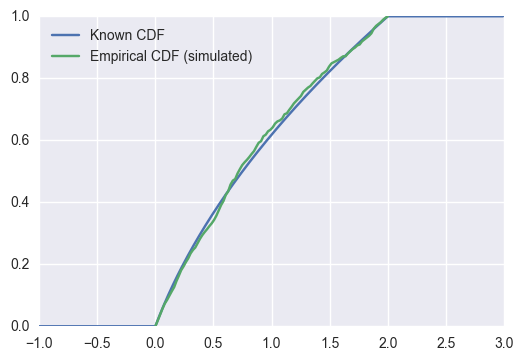

In [4]:
def F(x):
    return_array = np.zeros(len(x))
    for i, val in enumerate(x):
        if val < 0:
            return_array[i] = 0
        elif val > 2:
            return_array[i] = 1
        else:
            return_array[i] = (np.sqrt(1 + 4 * val) - 1) / 2
    return return_array
    
simulate_rv_cdf(F)

## [Rejection Sampling](https://en.wikipedia.org/wiki/Rejection_sampling)

This lets us sample any rv with any distribution.

* Sample a point on the $x$ axis from the proposal distribution.
* Draw a vertical line at this $x$ position, up to the curve of the proposal distribution.
* Sample uniformly along this line from 0 to the maximum of the probability density function. If the sampled value is greater, return to step 1.

The important thing to note here is not every distribution can be simulated with every other distribution. Let $X$ be the distribution that we're interested in with pdf $f(x)$. Likewise define $Y$ to have $g(x)$. In order to simulate this, you need to be able to find a $c$ such that
$$
f(x) \le c \cdot g(x), \quad \forall x
$$
If such a $c$ does not exist, then you cannot use this simulation method.

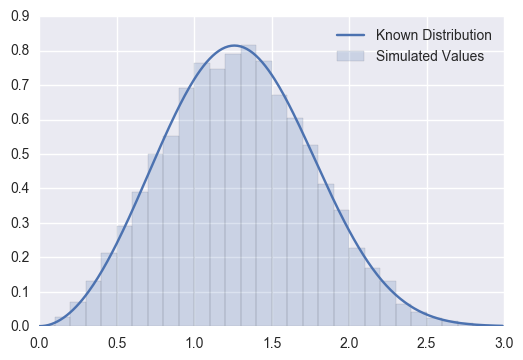

In [5]:
def simulate_rv(inverted_cdf_func, num):
    rvs = np.random.random(size=num)
    for i, val in enumerate(rvs):
        rvs[i] = inverted_cdf_func(val)
    return rvs

M = 0.1
f = lambda t: np.exp(-t)
g = lambda t: t**2 * np.exp(-t**3 / 3)
z = np.arange(0, 3, 0.01)

plt.figure()
plt.plot(z, g(z), label='Known Distribution')

num_samples = 10000
y_samples = simulate_rv(lambda t: (-3 * np.log(1 - t))**(1/3), num_samples)
unif_samples = np.random.random(size=num_samples)
rvs = []

for i in range(num_samples):
    if unif_samples[i] < (f(y_samples[i]) / (M * g(y_samples[i]))):
        rvs.append(y_samples[i])

hist, bins = np.histogram(rvs, np.arange(0, 3, 0.1), density=True)
plt.bar(bins[:-1], hist, 0.1, alpha=0.2, label='Simulated Values')
plt.legend(loc=0)
plt.show()

# Introduction to Markov Chains

The **Markov Property** is the fact that given some state $X_n$ in a system, no other information is needed to predict $X_{n+1}$.

We can draw Markov chains (which describe the probabilities that a system switches states) using adjacency matrices with weighted edges. Important: The rows of these matrices must add up to $1$.

matrix([[ 0.5,  0. ,  0.5],
        [ 0.3,  0. ,  0.7],
        [ 0. ,  1. ,  0. ]])

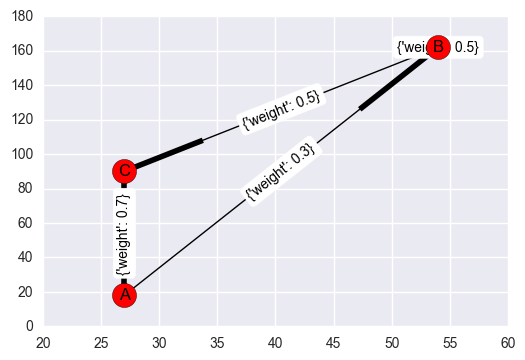

In [16]:
g = nx.DiGraph()
g.add_edge('A', 'B', weight=0.3)
g.add_edge('A', 'C', weight=0.7)
g.add_edge('B', 'C', weight=0.5)
g.add_edge('C', 'A', weight=1)
g.add_edge('B', 'B', weight=0.5)
display(nx.adjacency_matrix(g).todense())
plt.figure()
layout = nx.drawing.nx_pydot.graphviz_layout(g, prog='dot')
nx.draw_networkx(g, layout)
nx.draw_networkx_edge_labels(g, layout)
plt.show()

These matrices can be defined with a transition function as well, which is of the form

$$
p(i, j) = P(X_{n+1} = j \, | \, X_n = i)
$$

## Multistep Transition Probabilities

The issue with the above definition is that it gives us the probability of a state change in a single step. We also care about the probability of going from $i$ to $j$ in $m > 1$ steps, which is defined as the following.

$$
p^m (i, j) = P(X_{n + m}=j \, | \, X_n = i)
$$

Where $p^m$ is defined as the $mth$ power of the single step transition matrix.

## Classification of States

**Strong Markov Property -** Suppose $T$ is a stopping time. Given that $T = n$ and $X_T = y$, any other information about $X_0, \ldots, X_T$ is irrelevant for predicting the future, and $X_{T_k}$, $k \ge 0$ behaves like the Markov chain with initial state $y$.

* A transient state is one that after some point the Markov chain never visits again.
* On the other hand, a recurrent chain is infinitely visited.

As an example, in the following chain, states $0$ and $4$ are recurrent, while the others are transient.

$$
\left[\begin{array}{ccccc}
1 & 0 & 0 & 0 & 0\\
0.6 & 0 & 0.4 & 0 & 0\\
0 & 0.6 & 0 & 0.4 & 0\\
0 & 0 & 0.6 & 0 & 0.4\\
0 & 0 & 0 & 0 & 1\\
\end{array}\right]
$$

We say that $x$ communicates with $y$ and write $x \to y$ if there is a positive probability of reaching $y$ starting from $x$ in some given Markov Chain.

A set $A$ of nodes in a Markov Chain is closed if it is impossible to get out of. A set $B$ is called irreducible if any two states in the set communicate with each other.

If $C$ is a finite closed and irreducible set, then all states in $C$ are recurrent.

If the state space of $S$ is finite, then $S$ can be written down as a disjoint union of transient states and closed irreducible sets of recurrent states.

If $x$ is recurrent, and $x \to y$, then $y$ is recurrent.

In a finite closed set, there has to be at least one recurrent state.

## Stationary Distributions

The stationary distribution of some Markov Chain is simply a vector just that for the chain $S$,

$$
\pi S = \pi
$$

The general two state transition matrix

$$
\left[\begin{array}{cc}
1 - a & a\\
b & 1 - b\\
\end{array}\right]
$$

has solution

$$
\pi_1 = \frac{b}{a+b} \qquad \pi_2 = \frac{a}{a+b}
$$

Suppose that the $k \times k$ transition matrix $p$ is irreducible. Then there is a unique solution to $\pi p = \pi$ with $\sum_x \pi_x = 1$ and we have $\pi_x > 0$ for all $x$.

# Exam 1 Review Session

## Question 1

Consider a Markov chain with state space $\{1, 2, 3\}$ and probability matrix

$$
p = \left[\begin{array}{ccc}
0 & 0 & 1\\
1 & 0 & 0\\
1/2 & 1/2 & 0
\end{array}\right]
$$

1. Represent $p$ as a directed graph with weighted edges.
2. Which states are recurrent? Which are transient? All states are recurrent because S is finite, closed, and irreducible.
3. Is this chain irreducuble? - Is it possible to visit any state from any other state via positive probability? Yes, because 1 visits 2 and 3, and 2/3 visit 1.

## Question 2

If $X\sim Geom(p)$ with $0 < p \le 1$ then the mgf of $X$ is

$$
\phi_X(t) = \frac{1}{1-p} \cdot \left( \frac{1}{1 - (1 - p)e^t} - 1\right)
$$

1. Expected value of $X$?
$$
\phi_X^\prime(0) = \frac{1}{p}
$$
2. Variance of $X$?
$$
\phi_X^{\prime\prime}(0) - \phi_X^\prime(0)^2
$$

## Question 3

The goal of this problem is to make sense of the statement: *"If a Markov chain starts stationary then it stays stationary"*. For this consider a Markov chain $X={(X_n)}_{n \ge 0}$ over certain finite state space $S$, with initial distribution $\mu$ and probability transition matrix $p$.

1. Show that $X_1$ has distribution $\mu p$, i.e. for each $x$, $\mathbb{P}(X_1 = x) = (\mu p)(x)$.
$$
P(X_1 = x) = \sum_y P(X_1=x, X_0 = y)\\
\Rightarrow \sum_y P(X_1 = x \, | \, X_0 = y) \cdot P(X_0 = y)\\
\Rightarrow \sum_y \mu(y) \cdot p(y, x) = (\mu p)(x)
$$
2. Next, show that if $X_n$ has distribution $\mu p^n$ then $X_{n+1}$ has distribution $\mu p^{n+1}$.
$$
P(X_{n + 1} = x) = \sum_y P(X_{n+1} = x \, | \, X_n = y) P(X_n = y)\\
\Rightarrow \sum_y p(y, x) (\mu p^n)(y) = \mu p^{n+1}
$$

## Question 4

Let $X$ and $Y$ be random variables with probability density functions $f(x)$ and $g(x)$ respectively, where

$$
f(x) = \begin{cases}
2 x e^{-x^2} & x \ge 0\\
0 & x < 0
\end{cases}\\
g(x) = \begin{cases}
x e^{-x} & x \ge 0\\
0 & x < 0
\end{cases}
$$

1. Can you simulate $X$ from $Y$ using the Acceptance-Rejection algorithm? Explain. In the affirmative case, provide pseudo-code. T/F - $f(x) \le c \cdot g(x), \forall x$. We need to find $c$.
$$
\max_{x \ge 0} \frac{f(x)}{g(x)} \le c
$$
Yes, you can.
2. Conversely, can you simulate $Y$ from $X$? Explain. Provide pseudo code in the affirmative case. Flip the two.
No you can't.